# Détection de fraudes de cartes de crédit

## Introduction

L'objectif du projet consiste en l'élaboration d'algorithmes de classification capables de détecter les transactions frauduleuses dans un dataset kaggle de transactions de cartes de crédit. Les données peuvent être trouvées [ici](https://www.kaggle.com/mlg-ulb/creditcardfraud).

Les cas de fraudes ne représentant que 0.173% du nombre total de transactions, l’implémentation des modèles et les métriques de mesures de performance utilisées doivent être adaptées aux données fortement débalancées. Il est également souhaitable que la classification soit sensible, c’est-à-dire que le taux des faux positifs soit minimal, puisque l'institution bancaire ne veut pas déranger inutilement ses clients.


## Plan

* Exploration des données
  * Métriques
* Prétraitement
  * Normalisation
* Méthodologie
  * Ensembles d'entraînement et de test origniaux
* Régression logistique
  * Sélection des hyperparamètres
  * Évaluation
* Undersampling aléatoire
  * Sélection de modèle
  * Évaluation


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time as t
import warnings
warnings.filterwarnings("ignore")

# Preprocessing
from sklearn.preprocessing import StandardScaler

# Model Selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import ParameterGrid
from imblearn.pipeline import make_pipeline

# Resampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import ClusterCentroids
from imblearn.over_sampling import SMOTE

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

# Performance metrics
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, precision_score, recall_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score


## Exploration des données

Le dataset contient 284 807 exemples ayant chacun 31 traits caractéristiques numériques dont le temps et le montant de la transaction. Les 28 autres proviennent d'une analyse en composante principale (PCA) effectuée pour anonymiser les données.

In [2]:
df = pd.read_csv("data/creditcard.csv")
print('shape: ', df.shape)
df.head(n=5)

shape:  (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,...,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


Les exemples non-frauduleux sont étiquetés par la classe 0 et les exemples frauduleux par la classe 1. Seulement 492 (0.173%) des exemples sont de la classe 1.

In [4]:
fraud_count = df['Class'].value_counts()[1]
fraud_ratio = np.around(fraud_count/len(df)*100, 3)
print("Nombre de fraudes:", fraud_count)
print("Taux de fraudes:", fraud_ratio, '%')

Nombre de fraudes: 492
Taux de fraudes: 0.173 %



### Métriques

Les données sont extrèmements débalancées. Le classifieur risque de mémoriser que les données sont débalancées et d'assumer que la majorité des exemples sont des cas non-frauduleux (sur-apprentissage) plutôt que de détecter les liens dans les traits caractéristiques permettant réellement de déterminer si une transaction est une fraude.

Les cas de fraudes ne représentant que 0.172% du nombre total de transactions, l’implémentation des modèles et les métriques de mesures de performance utilisées doivent être adaptées aux données fortement débalancées. En effet, le taux de classifications (accuracy) n'est pas une mesure de performance naturelle lorsque les données sont débalancées. Pour l'illustrer, considérons un classifieur qui prédit la classe '0' à tous les nouveaux exemples de tests. Un tel classifieur obtiendrait un taux de classifications correctes de 99.827% sans détecter aucune fraude. Un tel classifieur est incapable de généraliser, même si son taux de classifications est élevé.

D'autres métriques basées sur la notion de vrai positif, faux positif, vrai négatif et faux négatif sont plus naturelles pour évaluer la performance d'un dataset débalancé.

- vrais positifs (VP): Nombre de fraudes détectées.


- faux positifs (FP): Nombre de non-fraudes classées comme fraudes.


- vrais négatifs (VN): Nombre de non-fraudes classées correctement.


- faux négaitfs (FN): Nombre de fraudes classées qui ne sont pas détectées.

On peut aussi énoncer les définitions pour VP, FP, VN et FN symétriquement pour la classe non-fraude.

Soit $N$ le nombre total d'exemples.

- Accuracy $:=\frac{VP+VN}{N}$


- Precision $:=\frac{VP}{VP+FP}$


- Recall $:=\frac{VP}{VP+FN}$


- f1-score $:=2\ \frac{\text{precision}\ \times\ \text{recall}}{\text{precision}\ +\ \text{recall}}$


- Courbe ROC: Courbe de VP en fonction de FP pour un classifieur binaire.


- Roc Auc Score: Aire sous la courbe ROC.


Le recall nous est particulièrement intéressant comme il s'agit le taux de fraudes détectées.

"Many machine-learning techniques, such as neural networks, make more reliable predictions from being trained with balanced data. Certain analytical methods, however, notably linear regression and logistic regression, do not benefit from a balancing approach." (Wikipedia)

Dotons-nous d'une fonction pour imprimer ces métriques.

In [5]:
def print_metrics(y_true, y_pred, title=''):
    print(title,'\n')
    print('Accuracy:', accuracy_score(y_true, y_pred))
    confusion_m = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = confusion_m.ravel()
    
    print('\ntrue positives\tfalse positives\tfalse negatives\ttrue negatives')
    print('%.0f\t\t%.0f\t\t%.0f\t\t%.0f'% (tn, fp, fn, tp))

    metrics = precision_recall_fscore_support(y_true, y_pred, beta=1.0)
    precision = metrics[0]
    recall = metrics[1]
    f1 = metrics[2]
    support = metrics[3]
    print('\nClass\t\t 0\t\t1')
    print('Precision\t', '%.2f\t\t%.2f'% (precision[0], precision[1]))
    print('recall\t\t', '%.2f\t\t%.2f'% (recall[0], recall[1]))
    print('f1\t\t', '%.2f\t\t%.2f'% (f1[0], f1[1]))
    print('support\t\t', '%.2f\t%.2f'% (support[0], support[1]))

## Pré-traitement

### Normalisation
On voudrait normaliser les colonnes Time et Amount comme pour les colonnes V1 à V28. Le but principal de cette normalisation est d'aider les techniques de convergences utilisées pour l'optimisation.

In [6]:
# Standardize features by removing the mean and scaling to unit variance
scaler = StandardScaler()

time = df['Time'].values.reshape(-1, 1)
amount = df['Amount'].values.reshape(-1, 1)
norm_time = scaler.fit_transform(time)
norm_amount = scaler.fit_transform(amount)
df.insert(0, 'norm_time', norm_time)
df.insert(0, 'norm_amount',norm_amount)
df.drop(['Time', 'Amount'], axis=1, inplace=True)
df.head()

,norm_amount,norm_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,0.244964,-1.996583,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.342475,-1.996583,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,1.160686,-1.996562,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,0.140534,-1.996562,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,-0.073403,-1.996541,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


## Méthodologie

On doit s'assurer d'utiliser convenablement les méthodes de resample puisqu'elles modifient la distribution des données.

Premièrement, on sépare les données originales en ensembles d'entraînement et de test. Ensuite, pour la sélection du modèle, on utilise la validation croisée pour tester les différentes combinaisons de paramètres pour chaque modèle. Une fois un modèle choisi, on estime sa performance de généralisation sur l'ensemble de test original dont les exemples sont inconnus au prédicteur. L'estimation de la performance est donc non biaisée.

Dans la phase de sélection du modèle des méthodes de resample, il est important de resample durant la validation croisée. Sinon on modifie forcément l'ensemble de validation et le prédicteur est optimisé pour des données resamplées. Le resample ne doit qu'agir sur l'entraînement pour que l'ensemble de validation corresponde à la vraie distribution.

### Ensembles d'entraînement et de test origniaux

In [7]:
df.sample(random_state=0)

inputs, outputs = df.drop('Class', axis=1), df['Class']

# If stratify not None, data is split in a stratified fashion, using this as the class labels
X_train, X_test, y_train, y_test = train_test_split(inputs, outputs, test_size=0.3, random_state=0, stratify=outputs)

# Verify if distributions are the same
print('Ratio de fraudes (Train):', y_train.value_counts()[1]/y_train.shape[0] * 100)
print('Ratio de fraudes (Test):', y_test.value_counts()[1]/y_test.shape[0] * 100)

# Create a new dataframe for training set
train_df = X_train.copy()
train_df['Class'] = y_train
train_df.sample(random_state=0)

X_train, y_train = X_train.values, y_train.values
X_test, y_test = X_test.values, y_test.values

Ratio de fraudes (Train): 0.17254870488152324
Ratio de fraudes (Test): 0.17321489179921118


On peut définir une fonctionalité qui permet de faire un grid-search sur un dictionnaire de paramètres tout en resamplant l'ensemble d'entraînement durant la validation croisée.

In [8]:
metrics = {}
metrics['accuracy'] = accuracy_score
metrics['recall'] = recall_score

def grid_search_cv_resample(X_train, y_train, model, params, cv=5, resampler=None, metric='accuracy', verbose=True):
    """
    Returns the best model found by cross validation.
    """
    # Folds are made by preserving the percentage of samples for each class.
    skf = StratifiedKFold(n_splits=cv, shuffle=False)

    param_grid = ParameterGrid(params)
    best_params = None
    best_score = 0
    
    scoring = metrics[metric]
    
    time1 = t()
    for param_combination in param_grid:
        
        # Set params
        model.set_params(**param_combination)
        
        scores = []
        accuracy = []
        
        # Cross validation
        for train_index, val_index in skf.split(X_train, y_train):
            
            # Train-val split
            X_val, y_val = X_train[val_index], y_train[val_index] 
            X_train_resampler, y_train_resampler = X_train[train_index], y_train[train_index]
            # Resample training set
            if resampler is not None:
                X_train_resampler, y_train_resampler = resampler.fit_resample(X_train_resampler, y_train_resampler) # Shuffle this ?! 
            
            # Train - predict on validation
            model.fit(X_train_resampler, y_train_resampler)
            pred = model.predict(X_val)
            
            # Evaluate performance
            scores.append(scoring(y_val, pred))
            # Only report results for the class specified by pos_label (=1). 
            # This is applicable only if targets (y_{true,pred}) are binary.

        score = np.mean(scores)
        
        if score > best_score:
            best_score, best_params = score, param_combination

    time2 = t()
    if verbose:
        print('\nBest params', best_params)
        print(f'{metric} score:', best_score)
        print('Time:', time2-time1)
    
    return model.set_params(**best_params)


Similairement, voici une fonctionalité qui permet d'estimer la performance d'un estimateur par validation croisée.

In [9]:
def print_metrics_resample(X, y, model, cv=5, resampler=None):
    
    # Folds are made by preserving the percentage of samples for each class.
    skf = StratifiedKFold(n_splits=cv, shuffle=False)
    
    precision = []
    recall = []
    f1 = []
    support = []
    accuracy = []
    
    # Cross validation
    for train_index, val_index in skf.split(X, y):

        # Train-val split
        X_val, y_val = X[val_index], y[val_index] 
        X_train_resampler, y_train_resampler = X[train_index], y[train_index]
        # Resample training set
        if resampler is not None:
            X_train_resampler, y_train_resampler = resampler.fit_resample(X_train_resampler, y_train_resampler) # Shuffle this ?! 

        # Train - predict on validation
        model.fit(X_train_resampler, y_train_resampler)
        pred = model.predict(X_val)

        # Evaluate performance
        metrics = precision_recall_fscore_support(y_val, pred, beta=1.0, labels=[0,1], average=None)
        precision.append(metrics[0])
        recall.append(metrics[1])
        f1.append(metrics[2])
        support.append(metrics[3])
        accuracy.append(accuracy_score(y_val, pred))
    
    precision = np.mean(precision, axis=0)
    recall = np.mean(recall, axis=0)
    f1 = np.mean(f1, axis=0)
    support = np.mean(support, axis=0)
    accuracy = np.mean(accuracy, axis=0)
    
    print('\nAccuracy\t', accuracy)
    print('\nClass\t\t 0\t\t1')
    print('Precision\t', '%.3f\t\t%.3f'% (precision[0], precision[1]))
    print('Recall\t\t', '%.3f\t\t%.3f'% (recall[0], recall[1]))
    print('f1\t\t', '%.3f\t\t%.3f'% (f1[0], f1[1]))
    print('Support\t\t', '%.3f\t%.3f'% (support[0], support[1]))
    
    

## Régression logistique 

Pour commencer, essayons d'implémenter naïvement un classifieur simple comme la régression logistique sur la totalité des données. On utilise le taux de bonnes classifications (accuracy) comme mesure de performance.

Comme discutter précédemment, on s'attend à ce que le modèle mémorise à tord le débalancement dans les données et qu'il éprouve des difficultées à voir ce qui caractérise vraiment une fraude. Il devrait prédire la classe 0 trop souvent.

### Sélection des hyperparamètres

In [10]:
log_reg = LogisticRegression()

# Tuning penalty and regularization using cross validation (5 folds)
params = {'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
log_reg_gs= GridSearchCV(log_reg, params, scoring='accuracy', cv=5, verbose=1) # Using accuracy as scoring metric 
log_reg_gs.fit(X_train, y_train)
print('Meilleurs paramètres:', log_reg_gs.best_params_)
print('Meilleur résultat (moyenne des résultats de validation croisée):', log_reg_gs.best_score_)
log_reg_best = log_reg_gs.best_estimator_

Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  70 out of  70 | elapsed:   48.0s finished


Meilleurs paramètres: {'C': 10, 'penalty': 'l2'}
Meilleur résultat (moyenne des résultats de validation croisée): 0.9992375756661026


### Évaluation

On évalue les performances sur l'ensemble de test pour estimer le pouvoir de généralisation.

In [11]:
log_reg_best.fit(X_train, y_train)
predictions = log_reg_best.predict(X_test)

print_metrics(y_test, predictions, 'Régression logistique simple')

Régression logistique simple 

Accuracy: 0.999204147794436

true positives	false positives	false negatives	true negatives
85282		13		55		93

Class		 0		1
Precision	 1.00		0.88
recall		 1.00		0.63
f1		 1.00		0.73
support		 85295.00	148.00


Bien que le taux de bonnes classifications semble élevé, le prédicteur n'a su que détecter 0,63% des fraudes. Ceci confirme notre hypothèse. On voudrait augmenter significativement cette quantité.

## Undersampling aléatoire

L'idée est d'entraîner un modèle sur un ensemble de données balancé tel quel 50% des données sont des fraudes. Modifier ainsi les données d'entraînement introduit un biais qui sert à compenser le risque de surapprentissage dû au fléau des données débalancées.

In [12]:
rand_under_sampler = RandomUnderSampler(sampling_strategy=1.0, random_state=0)

### Sélection de modèle

Peut-être devrait-on choisir une classe de fonction relativement peu expressive (basse capacité) parce que notre dataset under-samplé est petit durant la validation croisée, ce qui signifie qu'il a une grande variabilité. Un algorithme trop expressif risque de mémoriser le bruit et de surapprendre et mal généraliser puisque les données aberrantes ont un poids significatif. 

Comme les performances des combinaisons des hyperparamètres sont évaluées sur un ensemble de validation de la distribution originale (qui n'a pas été resamplée), alors le recall est une mesure de performance plus naturelle que l'accuracy pour la sélection du modèle. Le recall permet d'optimiser en fonction du taux de fraudes détectées.

In [13]:
# Logistic Regression
log_reg = LogisticRegression()

# Tuning penalty and regularization using cross validation
params = {'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
# params = [{'penalty': ['l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}, {'penalty': ['l1'], 'solver': ['liblinear'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}]
log_reg_best = grid_search_cv_resample(X_train, y_train, log_reg, params, cv=5, resampler=rand_under_sampler, metric='recall', verbose=True)


Best params {'C': 1000, 'penalty': 'l2'}
recall score: 0.9303069053708439
Time: 4.756361722946167


In [14]:
print_metrics_resample(X_train, y_train, log_reg_best, cv=5, resampler=rand_under_sampler)


Accuracy	 0.9498605647670519

Class		 0		1
Precision	 1.000		0.031
Recall		 0.950		0.930
f1		 0.974		0.060
Support		 39804.000	68.800


In [15]:
# SVM
svm_rbf = SVC()

# Tuning kernel, C, and degree for polynomial kernel
params = {'kernel': ['rbf'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
# params = [{'kernel': ['rbf'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}, {'kernel': ['poly'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000], 'degree': [0, 1, 2, 3, 4, 5]}]
svm_rbf_best = grid_search_cv_resample(X_train, y_train, svm_rbf, params, cv=5, resampler=rand_under_sampler, metric='recall', verbose=1)


Best params {'C': 1000, 'kernel': 'rbf'}
recall score: 0.9331202046035806
Time: 18.09032940864563


In [16]:
print_metrics_resample(X_train, y_train, svm_rbf_best, cv=5, resampler=rand_under_sampler)


Accuracy	 0.9426676802076932

Class		 0		1
Precision	 1.000		0.028
Recall		 0.943		0.933
f1		 0.970		0.054
Support		 39804.000	68.800


In [17]:
# knn
knn = KNeighborsClassifier()

# Tuning k
params = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
knn_best = grid_search_cv_resample(X_train, y_train, knn, params, cv=5, resampler=rand_under_sampler, metric='recall', verbose=1)


Best params {'n_neighbors': 1}
recall score: 0.9128303495311169
Time: 99.25095295906067


In [18]:
print_metrics_resample(X_train, y_train, knn_best, cv=5, resampler=rand_under_sampler)


Accuracy	 0.9360766891038759

Class		 0		1
Precision	 1.000		0.024
Recall		 0.936		0.913
f1		 0.967		0.047
Support		 39804.000	68.800


In [19]:
# Random Forest
rand_forest = RandomForestClassifier(random_state=0)

# Tuning number of trees
params = {'n_estimators': [1, 10, 100, 500]}
rand_forest_best = grid_search_cv_resample(X_train, y_train, rand_forest, params, cv=5, resampler=rand_under_sampler, metric='recall', verbose=1)


Best params {'n_estimators': 100}
recall score: 0.9128729752770675
Time: 14.845188856124878


In [20]:
print_metrics_resample(X_train, y_train, rand_forest_best, cv=5, resampler=rand_under_sampler)


Accuracy	 0.9717953071427143

Class		 0		1
Precision	 1.000		0.054
Recall		 0.972		0.913
f1		 0.986		0.101
Support		 39804.000	68.800


Les classifieurs donnent tous des résultats satisfaisants. La régression logistique et la machine à vecteurs de supports sont ceux ayant les plus grans recalls (\~93%), c'est-à-dire qu'ils sont ceux détectant le mieux les fraudes tout en ayant des taux de classifications raisonables (\~94%). 

La forêt d'arbres aléatoires a le plus haut taux de classification (\~97%) avec un recall raisonable (\~91%) pour la classe des fraudes. Si on se place dans la position d'une institution bancaire qui se satisfait d'un taux de détection de fraude > 90%, mais qui désire limiter absolument le taux de cas non-fraduleux incorrectement classés pour ne pas déranger inutilement sa clientèle, alors la forêt d'arbres aléatoires est le classifieur le plus intéressant.

### Évaluation

Évaluons le pouvoir de généralisation de sur

In [21]:
# New under-sampled df to retrain with more data

# Select a random sample of non-fraud exemples
fraud_df = train_df[train_df['Class']==1]
non_fraud_df = train_df[train_df['Class']==0]
rdm_non_fraud_df = non_fraud_df.sample(n=fraud_df.shape[0], random_state=0)

# New balanced df
under_sample_df = pd.concat([fraud_df, rdm_non_fraud_df])
under_sample_df = under_sample_df.sample(frac=1, random_state=0)

# Split random undersample (rus) data 
X_train_rus, y_train_rus = under_sample_df.drop('Class', axis=1), under_sample_df['Class']

under_sample_df.describe()

,norm_amount,norm_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
count,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000,...,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000,688.000000
mean,0.060000,-0.126195,-2.444678,1.901810,-3.638969,2.121004,-1.656680,-0.696165,-2.959041,0.188744,...,0.211573,0.440964,-0.010492,-0.019214,-0.028656,0.018229,0.025031,0.105320,0.059413,0.500000
std,0.899612,1.020022,5.697432,3.790652,6.336778,3.284833,4.299497,1.790023,6.034797,5.425015,...,1.097614,3.184309,1.287886,1.312333,0.569880,0.683639,0.463300,1.051400,0.405133,0.500364
min,-0.353229,-1.992624,-30.552380,-8.402154,-31.103685,-5.231828,-22.105532,-5.773192,-43.557242,-41.044261,...,-4.128186,-22.797604,-8.887017,-19.254328,-2.028024,-4.781606,-1.329589,-7.263482,-1.552593,0.000000
25%,-0.346083,-1.039764,-2.870879,-0.164501,-5.181646,-0.324236,-1.864221,-1.556634,-3.152655,-0.208914,...,-0.195058,-0.166346,-0.524324,-0.254264,-0.374835,-0.314790,-0.278314,-0.062918,-0.051460,0.000000
50%,-0.277386,-0.233224,-0.834366,0.945278,-1.417632,1.084360,-0.483200,-0.678117,-0.744855,0.178904,...,0.048539,0.161919,0.039776,-0.033762,0.024644,0.064023,-0.020932,0.058968,0.040077,0.500000
75%,0.046539,0.836434,1.048206,2.825485,0.193490,4.173330,0.397083,0.093819,0.229025,0.954627,...,0.483930,0.717166,0.610616,0.202751,0.378893,0.382632,0.356523,0.468181,0.227415,1.000000
max,8.146182,1.608807,2.328167,22.057729,3.177069,12.114672,11.095089,6.474115,5.431271,20.007208,...,11.059004,27.202839,8.361985,5.466230,3.508563,2.208209,1.246604,3.052358,1.779364,1.000000


Prédictions sur le test set.

In [28]:
log_reg_best.fit(X_train_rus, y_train_rus)
predictions = log_reg_best.predict(X_test)
print_metrics(y_test, predictions, 'Performance de régression logistique entraînée avec sub-sampling aléatoire sur l\'ensemble test')

Performance de régression logistique entraînée avec sub-sampling aléatoire sur l'ensemble test 

Accuracy: 0.926243226478471

true positives	false positives	false negatives	true negatives
79007		6288		14		134

Class		 0		1
Precision	 1.00		0.02
recall		 0.93		0.91
f1		 0.96		0.04
support		 85295.00	148.00


In [23]:
roc_auc_reg = roc_auc_score(y_test, predictions)
print('Roc Auc score', roc_auc_reg)

Roc Auc score régression logistique: 0.9158423943610648


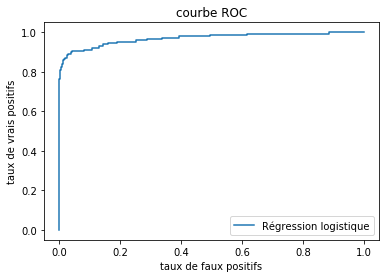

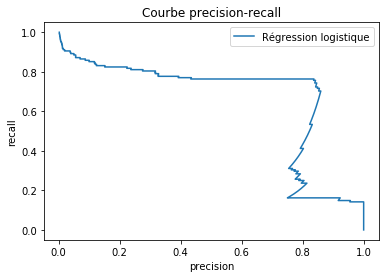

In [24]:
decision_function = log_reg_best.decision_function(X_test)

# ROC curves
log_reg_fpr, log_reg_tpr, log_reg_thresholds = roc_curve(y_test, decision_function)

plt.title('courbe ROC')
plt.plot(log_reg_fpr, log_reg_tpr, label='Régression logistique')
plt.xlabel('taux de faux positifs')
plt.ylabel('taux de vrais positifs')
plt.legend(loc='best')
plt.show()

# Precision-Recall curves
log_reg_precision, log_reg_recall, log_reg_thresholds = precision_recall_curve(y_test, decision_function)

plt.title('Courbe precision-recall')
plt.plot(log_reg_precision, log_reg_recall, label='Régression logistique')
plt.xlabel('precision')
plt.ylabel('recall')
plt.legend(loc='best')
plt.show()

On peut s'amuser à observer l'effet du threshold pour la classification. Peut-être peut-on gagné un peu d'accuracy sans trop diminuer le recall pour la classe 1.

In [26]:
thresholds = np.arange(0, 100, 10)/100 # For fraud

predictions_proba = log_reg_best.predict_proba(X_test)[:,-1]

for threshold in thresholds:
    # Prediction
    predictions = (predictions_proba >= threshold).astype(int)
    
    # Quality 
    confusion_m = confusion_matrix(y_test, predictions)
    tn, fp, fn, tp = confusion_m.ravel()
    print('\nThreshold=', threshold)
    print('Accuracy=', accuracy_score(y_test, predictions))
    print('true positives\tfalse positives\tfalse negatives\ttrue negatives')
    print('%.0f\t\t%.0f\t\t%.0f\t\t%.0f'% (tn, fp, fn, tp))
    print('Precision=', precision_score(y_test, predictions))
    print('Recall=', recall_score(y_test, predictions))


Threshold= 0.0
Accuracy= 0.0017321489179921118
true positives	false positives	false negatives	true negatives
0		85295		0		148
Precision= 0.0017321489179921118
Recall= 1.0

Threshold= 0.1
Accuracy= 0.7834579778331753
true positives	false positives	false negatives	true negatives
66800		18495		7		141
Precision= 0.0075660012878300065
Recall= 0.9527027027027027

Threshold= 0.2
Accuracy= 0.8505319335697482
true positives	false positives	false negatives	true negatives
72533		12762		9		139
Precision= 0.010774358576854508
Recall= 0.9391891891891891

Threshold= 0.3
Accuracy= 0.8852685416008333
true positives	false positives	false negatives	true negatives
75504		9791		12		136
Precision= 0.01370001007353682
Recall= 0.918918918918919

Threshold= 0.4
Accuracy= 0.9083716629799984
true positives	false positives	false negatives	true negatives
77479		7816		13		135
Precision= 0.016978996352660043
Recall= 0.9121621621621622

Threshold= 0.5
Accuracy= 0.926243226478471
true positives	false positives	false 

Dépendemment du contexte, on pourrait choisir différents thresholds. Avec un threshold de 0.

## Undersampling cluster

Une autre façon de ne sélectionner qu'une partie des exemples de la classee majoritaire pour balancer les données est l'undersampling par centroïdes. Il s'agit de performer K-Mean sur l'ensemble majoritaire pour sélectionner les exemples à conserver. Cette méthode s'assure alors de sélectioner des éléments moyens et typiques qui devraient bien représenter la classe majoritaire.

Perform under-sampling by generating centroids based on clustering methods.

"Method that under samples the majority class by replacing a cluster of majority samples by the cluster centroid of a KMeans algorithm. This algorithm keeps N majority samples by fitting the KMeans algorithm with N cluster to the majority class and using the coordinates of the N cluster centroids as the new majority samples." Documentation
Try RandomUnderSampler maybe ... 

In [ ]:
under_sampler = ClusterCentroids(sampling_strategy='majority', random_state=0)
X_resampled, y_resampled = under_sampler.fit_resample(X_train, y_train) # This takes so long

In [ ]:
log_reg_cluster = LogisticRegression()
params = {'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
log_reg_cluster = GridSearchCV(log_reg_cluster, params, scoring='accuracy', cv=5, verbose=1)
log_reg_cluster.fit(X_resampled, y_resampled)
print(log_reg_cluster.best_params_)
print('Meilleur résultat (moyenne des résultats de validation croisée):', log_reg_cluster.best_score_)
log_reg_cluster_best = log_reg_cluster.best_estimator_

In [ ]:
predictions = log_reg_cluster.predict(X_test)
print_metrics(y_test, predictions)

## SMOTE

Génère des exemples synthétiques entre les exemples de la classe minoritaire.

In [ ]:
smote_os = SMOTE(sampling_strategy='minority', random_state=0)
X_resampled, y_resampled = smote_os.fit_resample(X_train, y_train)

In [ ]:
log_reg_smote = LogisticRegression()

params = {'penalty': ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
log_reg_smote = GridSearchCV(log_reg_smote, params, scoring='accuracy', cv=5, verbose=1)
log_reg_smote.fit(X_resampled, y_resampled)
print(log_reg_smote.best_params_)
print('Meilleur résultat (moyenne des résultats de validation croisée):', log_reg_smote.best_score_)
log_reg_smote_best = log_reg_smote.best_estimator_

In [ ]:
predictions = log_reg_smote_best.predict(X_test)
print_metrics(y_test, predictions)

## Références
[Addressing the Curse of Imbalanced Training Sets: One-Sided Selection](https://sci2s.ugr.es/keel/pdf/algorithm/congreso/kubat97addressing.pdf)

[Credit Fraud Detector (notebook kaggle)](https://www.kaggle.com/kernels/scriptcontent/16695845/download)

[Toward data science article](https://towardsdatascience.com/detecting-financial-fraud-using-machine-learning-three-ways-of-winning-the-war-against-imbalanced-a03f8815cce9)

[Evaluation Metrics, ROC-Curves and imbalanced datasets](http://www.davidsbatista.net/blog/2018/08/19/NLP_Metrics/)

[Subsampling and Oversampling Wikipedia](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis#Undersampling_techniques_for_classification_problems)

[ROC curve google](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)